In [33]:
#-configuration---------
transmissions = 0.01:0.01:0.99
temp = 1e-7
integration = (-15.0, 15.0)
voltage = (0.05, 0.01, 5.50)
#-----------------------
;

In [34]:
#-checks----------------
if temp <= 0
    println("Temperature is 0.\n Assuming default value of 1e-7")
    temp = 1e-7
end

@assert voltage[1] >= 0.005 "Voltage must be greater or equal to 0.005"
#----------------------

In [35]:
#-dependencies----------
using ProgressMeter
using Plots
using JLD2
#----------------------

In [36]:
#-Constants------------
const G₀ = 7.748091729e-5
const e = 1.602176634e-19
const h = 6.62607015e-34
#----------------------
;

In [37]:
# convert input parameters
transmissions = collect(transmissions)
voltages = collect(voltage)

# find working dirs
start_dir = @__DIR__
temp_dir = joinpath(@__DIR__, "..", "temp")
bin_dir = joinpath(@__DIR__, "..", "bin")
plots_dir = joinpath(@__DIR__, "..", "plots")
data_dir = joinpath(@__DIR__, "..", "data")

# copy the binary to the temp directory
run(`cp $bin_dir/iv $temp_dir`)

# create the running script
open(joinpath(temp_dir, "do.sh"), "w") do file
    write(file, "cat temp_config.txt | ./iv")
end

cd(temp_dir)

In [38]:
# curve dictionary [τ] = (x, y)
curves = Dict{Float64,Tuple{Vector{Float64},Vector{Float64}}}()

progress = Progress(length(transmissions), 1, "Running simulations")
for t in transmissions
    next!(progress)

    open(joinpath(temp_dir, "temp_config.txt"), "w") do file
        write(file, "  $t  $temp\n")
        write(file, "$(integration[1])  $(integration[2])\n")
        write(file, "  $(voltage[1])  $(voltage[3])  $(voltage[2])\n")
    end

    run(`bash do.sh`)

    open(joinpath(temp_dir, "iv.dat"), "r") do file
        x = []
        y = []
        data = read(file, String)
        lines = split(data, "\n")
        for line in lines
            line = strip(line)
            parts = split(line)
            filter!(x -> x != "", parts)
            if length(parts) < 2
                continue
            end
            push!(x, parse(Float64, parts[1]))
            push!(y, parse(Float64, parts[2]))
        end
        curves[t] = (x, y)
    end
end
const raw = copy(curves);

Running simulations 100%|████████████████████████████████| Time: 0:10:10


In [39]:
curve_processed = Dict{Float64,Tuple{Vector{Float64},Vector{Float64}}}()
for (τ, curve) in curves
    x, y = curve
    x = copy(x)
    y = copy(y)
    G = G₀ * τ
    y .*= (2*e^2 / h)
    y ./= G
    curve_processed[τ] = (x, y)
end
const normalized = copy(curve_processed);

In [40]:
curve_derived = Dict{Float64,Tuple{Vector{Float64},Vector{Float64}}}()
for (τ, curve) in curve_processed
    x, y = curve
    y = diff(y) ./ diff(x)
    x = x[1:end-1]
    curve_derived[τ] = (x, y)
end
const derived = copy(curve_derived);

In [41]:
jldopen(joinpath(data_dir, "iv.jld2"), "w") do file
    file["raw"] = raw
    file["normalized"] = normalized
    file["derived"] = derived
end;

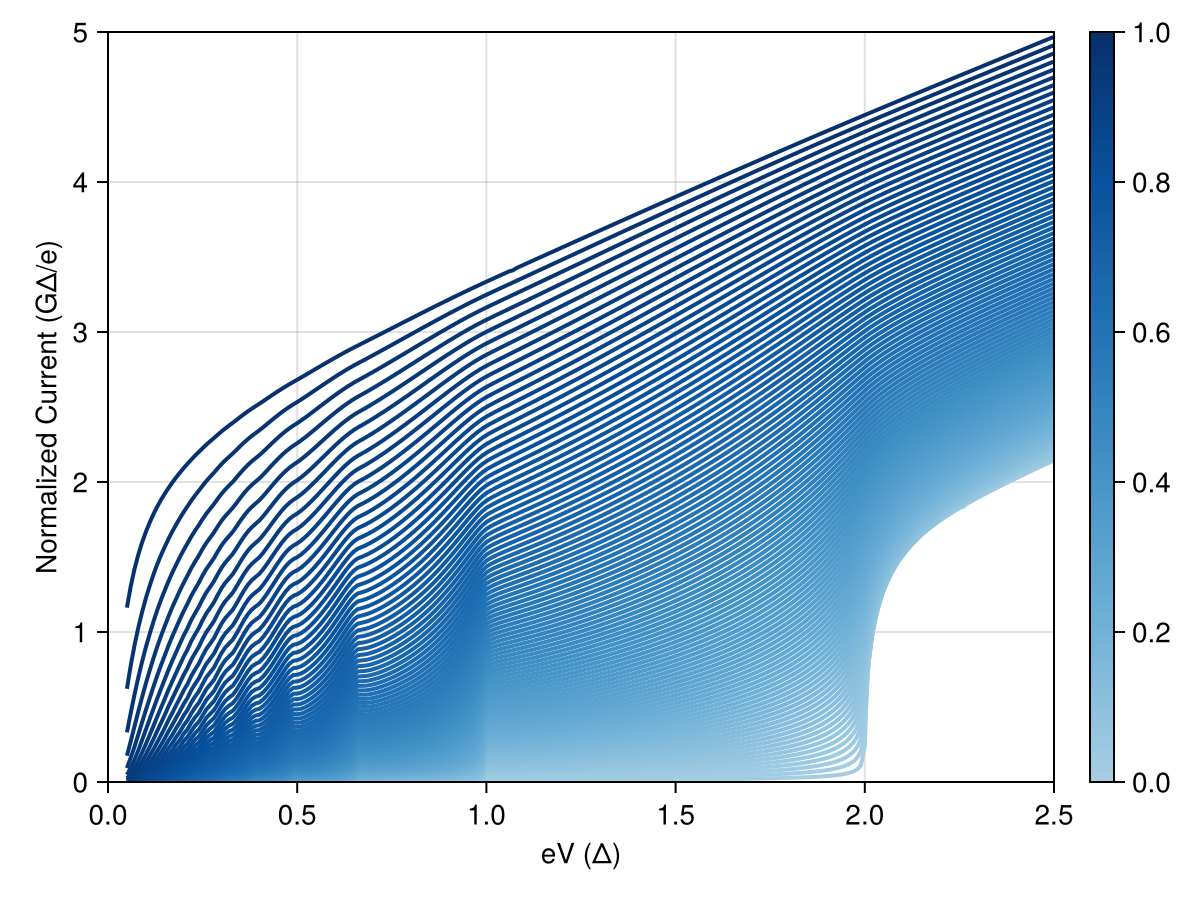

CairoMakie.Screen{SVG}


In [42]:
using CairoMakie
using ColorSchemes

t_values = sort(collect(keys(normalized)))

max_clip = 1.0  
min_clip = 0.35

clip_normalize(t, min_val, max_val) = t_rel = min_val + t * (max_val - min_val)

see = get(ColorSchemes.Blues, range(min_clip, max_clip, length=256))

fig = Figure()
ax = Axis(fig[1, 1])

for (i, t) in enumerate(t_values)
    x, y = normalized[t]
    color_idx = clip_normalize(t, min_clip, max_clip)
    lines!(ax, x, y, color=cgrad(:Blues)[color_idx], linewidth=2)
end
ax.xlabel = "eV (Δ)"
ax.ylabel = "Normalized Current (GΔ/e)"
ax.limits = (0, 2.5), (0, 5)

Colorbar(fig[1, 2], colormap=see, ticks=0:0.2:1)

display(fig)
save(joinpath(plots_dir, "iv2.svg"), fig)

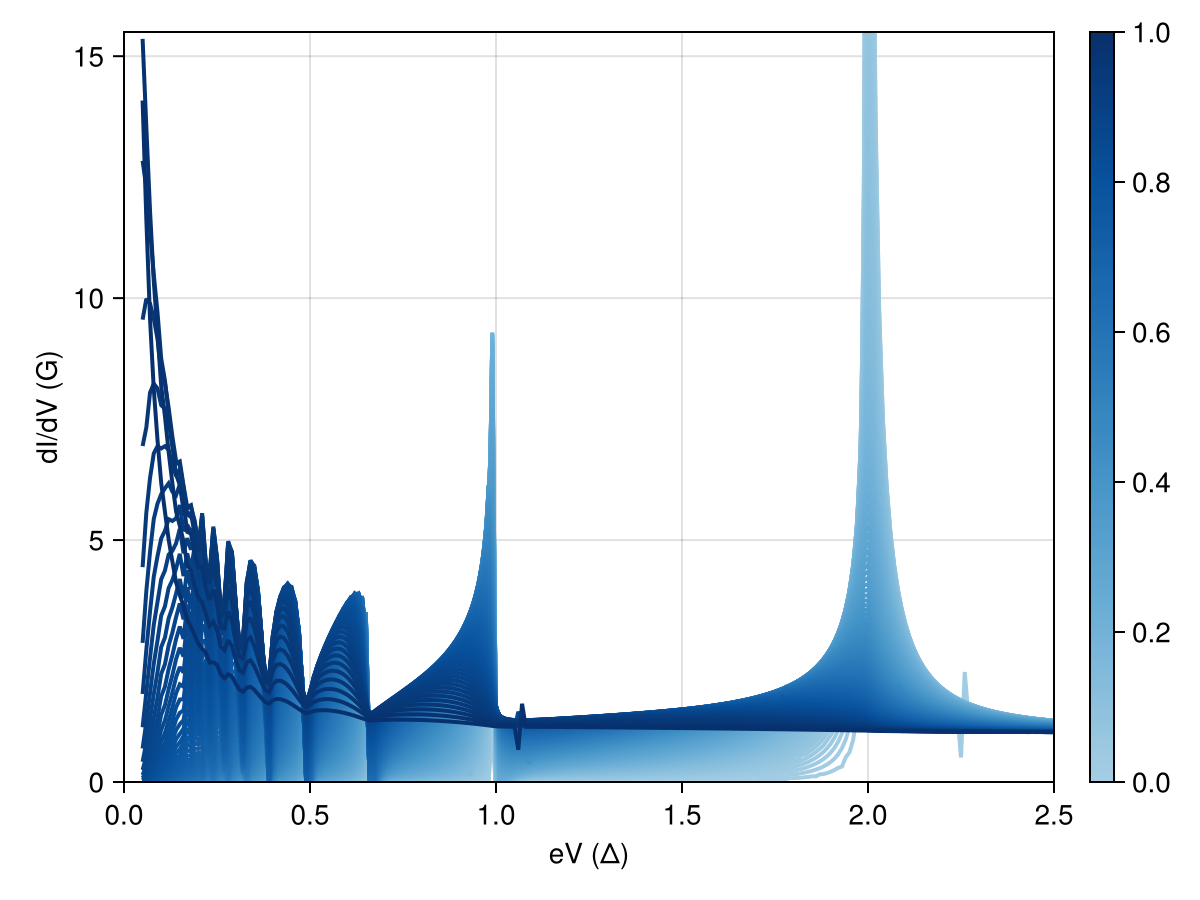

CairoMakie.Screen{SVG}


In [43]:
fig = Figure()
ax = Axis(fig[1, 1])

for (i, t) in enumerate(t_values)
    x, y = derived[t]
    color_idx = clip_normalize(t, min_clip, max_clip)
    lines!(ax, x, y, color=cgrad(:Blues)[color_idx], linewidth=2)
end
ax.xlabel = "eV (Δ)"
ax.ylabel = "dI/dV (G)"
ax.limits = (0, 2.5), (0, 15.5)

Colorbar(fig[1, 2], colormap=see, ticks=0:0.2:1)
display(fig)
save(joinpath(plots_dir, "didv.svg"), fig)